In [2]:
import networkx as nx
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


In [3]:
G = nx.read_gml("../results/alzheimers_network.gml")
G.number_of_nodes(), G.number_of_edges()


(101, 1308)

In [4]:
pos_edges = list(G.edges())
len(pos_edges)


1308

In [5]:
all_non_edges = list(nx.non_edges(G))

np.random.seed(42)
neg_edges = np.random.choice(
    len(all_non_edges),
    size=len(pos_edges),
    replace=False
)

neg_edges = [all_non_edges[i] for i in neg_edges]


In [6]:
def compute_features(G, edge_list):
    features = []

    for u, v in edge_list:
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = next(nx.jaccard_coefficient(G, [(u, v)]))[2]
        pa = next(nx.preferential_attachment(G, [(u, v)]))[2]

        features.append([cn, jc, pa])

    return np.array(features)


In [7]:
X_pos = compute_features(G, pos_edges)
X_neg = compute_features(G, neg_edges)

X = np.vstack([X_pos, X_neg])
y = np.array([1]*len(X_pos) + [0]*len(X_neg))

X.shape, y.shape


((2616, 3), (2616,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [9]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict_proba(X_test)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)

roc_auc_lr


0.9853559744508491

In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
roc_auc_rf


0.9915322999428781

In [11]:
candidate_edges = neg_edges[:1000]   # subset for speed
X_candidates = compute_features(G, candidate_edges)

scores = rf.predict_proba(X_candidates)[:, 1]


In [11]:
predicted_links = pd.DataFrame({
    "gene_1": [e[0] for e in candidate_edges],
    "gene_2": [e[1] for e in candidate_edges],
    "prediction_score": scores
}).sort_values("prediction_score", ascending=False)

predicted_links.head(10)


,gene_1,gene_2,prediction_score
817,10023814510,10023830526,1.000000
702,10023807654,10023828170,0.998333
189,10023819047,10023812977,0.991667
819,10025909587,10025909612,0.920000
981,10023836054,10023806267,0.907444
511,10033668524,10033668638,0.897222
907,10023828170,10025911931,0.870000
219,10025913703,10023846133,0.867389
831,10025908848,10025911931,0.854944
769,10023810409,10023819047,0.830214


In [12]:
predicted_links.to_csv(
    "../results/ai_predicted_gene_interactions.csv",
    index=False
)


NameError: name 'predicted_links' is not defined

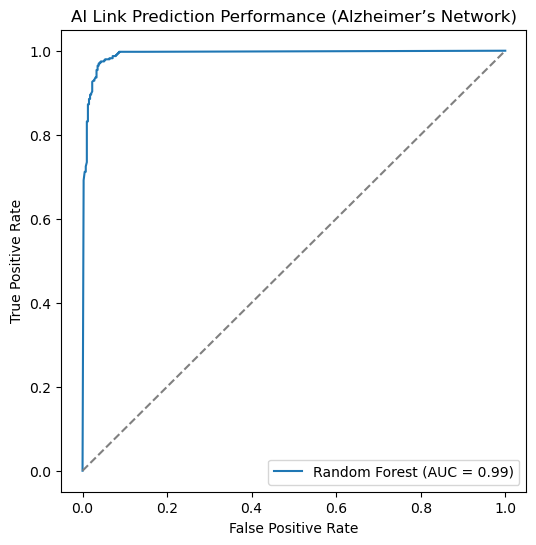

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import os

# Ensure figures folder exists
os.makedirs("../figures", exist_ok=True)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AI Link Prediction Performance (Alzheimer’s Network)")
plt.legend()

# Save
plt.savefig("../figures/roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Take top 20 predicted links
top_links = predicted_links.head(20)

# Build subnetwork
G_pred = nx.Graph()
G_pred.add_edges_from(
    zip(top_links["gene_1"], top_links["gene_2"])
)

# Plot
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G_pred, seed=42)

nx.draw(
    G_pred, pos,
    with_labels=True,
    node_size=400,
    font_size=8
)

plt.title("AI-Predicted Gene Interactions in Alzheimer’s Network")

# Save
plt.savefig("../figures/ai_predicted_subnetwork.png", dpi=300, bbox_inches="tight")
plt.show()


NameError: name 'predicted_links' is not defined